In [1]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from cryptocmd import CmcScraper
import talib

start_date = "31-03-2020"
end_date = "31-03-2022"
symbol = "BTC"

In [3]:
df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)
df = df.reset_index()
df["Percent Change"] = df["Close"] / df["Open"]
df["Moving"] = np.where(df["Percent Change"] > 1, 1, 0)
df["Varince"] = df["High"] - df["Low"]
df["RSI"] = talib.RSI(df["Close"])
df["OBV"] = talib.OBV(df["Close"], df["Volume"])
df["A/D Line"] = talib.AD(df["High"], df["Low"], df["Close"], df["Volume"])
df["MACD"], df["MACD-signal"], df["MACD-hist"] = talib.MACD(df["Close"])

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_49289/3374468197.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)


In [4]:
df.dropna(inplace=True)
df = df.reset_index().drop('index', axis=1)
date = pd.to_datetime(df.pop('Date'))

In [5]:
np.asarray([ df.T[i] for i in range(len(df)) ]).shape

(698, 15)

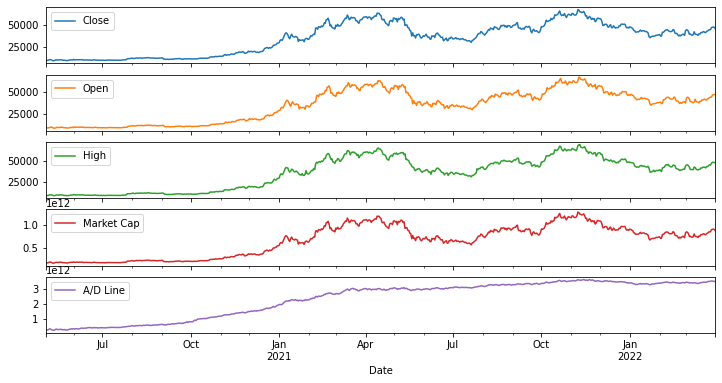

In [6]:
plot_cols = ['Close', 'Open', 'High', 'Market Cap', 'A/D Line']
plot_features = df[plot_cols]
plot_features.index = date
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,698.0,3.449979e+04,1.784991e+04,8.610386e+03,1.298646e+04,3.811893e+04,4.840680e+04,6.754974e+04
High,698.0,3.542105e+04,1.830845e+04,8.949898e+03,1.319475e+04,3.940069e+04,4.945785e+04,6.878963e+04
Low,698.0,3.348436e+04,1.729995e+04,8.374323e+03,1.283822e+04,3.662010e+04,4.701278e+04,6.638206e+04
Close,698.0,3.454585e+04,1.782205e+04,8.601796e+03,1.304219e+04,3.814124e+04,4.835383e+04,6.756683e+04
Volume,698.0,3.893639e+10,2.143111e+10,1.225260e+10,2.560532e+10,3.429453e+10,4.746481e+10,3.509679e+11
Market Cap,698.0,6.478980e+11,3.365019e+11,1.580592e+11,2.416317e+11,7.184039e+11,9.072966e+11,1.274831e+12
Percent Change,698.0,1.002892e+00,3.705455e-02,8.616244e-01,9.849443e-01,1.002553e+00,1.020677e+00,1.187972e+00
Moving,698.0,5.343840e-01,4.991740e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Varince,698.0,1.936693e+03,1.669427e+03,7.676101e+01,5.736528e+02,1.651215e+03,2.690397e+03,1.286462e+04
RSI,698.0,5.498446e+01,1.381568e+01,2.033876e+01,4.462285e+01,5.453164e+01,6.432978e+01,9.071943e+01


In [8]:
selected_feature = ['Close', 'Open', 'High', 'Market Cap', 'A/D Line']
target = "Close"

column_indices = {name: i for i, name in enumerate(df.columns)}

split_portion = (0.6, 0.20)

n = len(df)
train_df = df[selected_feature][: int(n * split_portion[0])]
val_df = df[selected_feature][int(n * split_portion[0]) : -int(n * split_portion[-1])]
test_df = df[selected_feature][-int(n * split_portion[-1]) :]

num_features = df[selected_feature].shape[1]

train_df.shape, val_df.shape, test_df.shape, num_features

((418, 5), (141, 5), (139, 5), 5)

In [9]:
train_df.reset_index().drop("index", axis=1).T[0]

Close         8.897469e+03
Open          8.983614e+03
High          9.167781e+03
Market Cap    1.633582e+11
A/D Line      2.086125e+11
Name: 0, dtype: float64

In [10]:
class StandardScaler():
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_mean = fit_data.mean()
        self.fit_std = fit_data.std()
        
    def transform(self, data):
        return (data - self.fit_mean) / self.fit_std
    
    def inverse_transform(self, trans_data):
        return trans_data * self.fit_std + self.fit_std
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [11]:
class MinMaxScaler():
    
    def __init__(self, scale_range=(0, 1)):
        self.a, self.b = scale_range
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_min = fit_data.min()
        self.fit_max = fit_data.max()
        
    def transform(self, data):
        return self.a + ((data - self.fit_min)*(self.b - self.a)) / (self.fit_max - self.fit_min)
    
    def inverse_transform(self, trans_data):
        return (trans_data - self.a) * (self.fit_max - self.fit_min) / ((trans_data - self.fit_min)*(self.b - self.a))
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [12]:
scale_range = train_df.max() - train_df.min()
scale_range["Close"]

54901.66172781

In [13]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

In [14]:
train_df

,Close,Open,High,Market Cap,A/D Line
0,0.005385,0.006797,0.003897,0.005153,0.000000
1,0.005662,0.005197,0.000125,0.005441,0.011323
2,0.007309,0.005508,0.002012,0.007073,0.017630
3,0.012148,0.007231,0.008255,0.011835,0.023747
4,0.024584,0.011864,0.018650,0.024047,0.042845
...,...,...,...,...,...
413,0.493546,0.490823,0.484851,0.496846,0.977129
414,0.420295,0.492244,0.478809,0.423579,0.962010
415,0.435394,0.419060,0.435363,0.438704,0.975106
416,0.457568,0.435328,0.461492,0.460906,0.980049


In [15]:
from window import WindowGenerator

WIDTH = 30
OFFSET = 2

wide_window = WindowGenerator(
    train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=WIDTH, label_width=WIDTH, shift=OFFSET,
    label_columns=[target]
)
wide_window

Window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
Label column name(s): ['Close']

In [16]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10, max_epochs=MAX_EPOCHS):
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=patience, mode='min'
    # )
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        # callbacks=[early_stopping]
                        )
    
    return history

In [17]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

2022-05-20 05:17:14.048948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
print(f'Input shape: {wide_window.example[0].shape}')
print(f'Output shape: {lstm_model(wide_window.example[0]).shape}')

Input shape: (30, 30, 5)
Output shape: (30, 30, 1)


In [19]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = lstm_model.evaluate(wide_window.val)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 12ms/step - loss: 0.0031 - mean_absolute_error: 0.0445


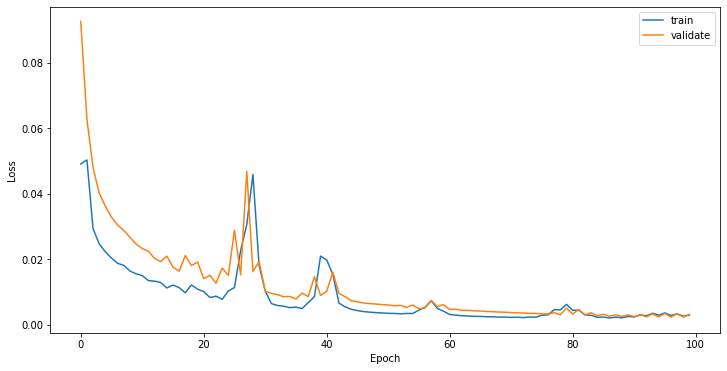

In [20]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

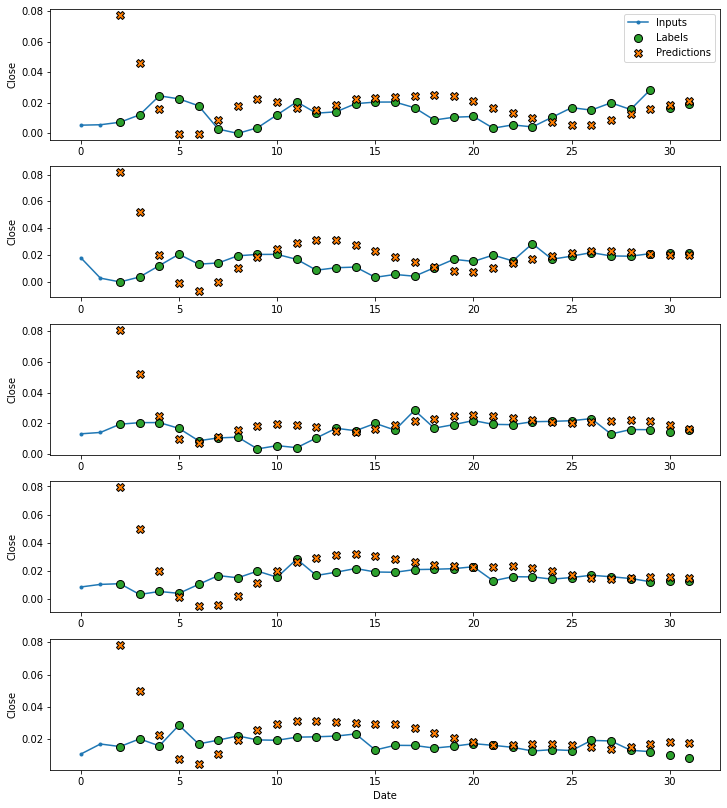

In [21]:
wide_window.plot(plot_col=target, model=lstm_model, max_subplots=5)

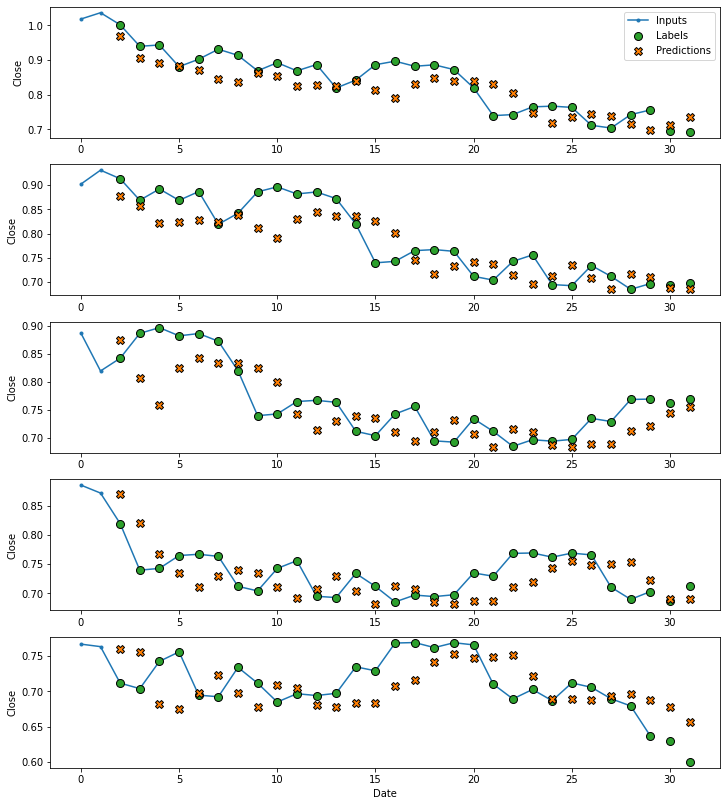

In [22]:
wide_window.plot(plot_col=target, model=lstm_model, example=wide_window.test, max_subplots=5)

In [23]:
print('Validation Loss')
print(f'MSE: {val_performance[0]}, MAE: {val_performance[1]}')
print('Test Loss')
print(f'MSE: {performance[0]}, MAE: {performance[1]}')

Validation Loss
MSE: 0.003129621036350727, MAE: 0.044523704797029495
Test Loss
MSE: 0.0017830048454925418, MAE: 0.03383682295680046


In [24]:
(val_performance[1] * scale_range)["Close"], (performance[1] * scale_range)["Close"]

(2444.4253796353846, 1857.6978079180547)

Window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

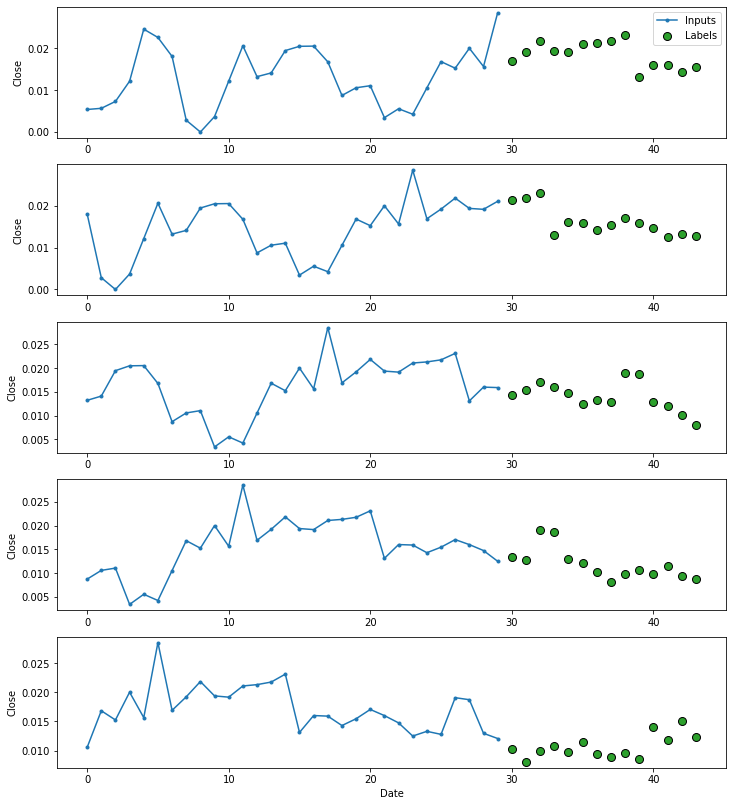

In [25]:
OUT_STEPS = 14
muti_window = WindowGenerator(
    test_df=test_df, val_df=val_df, train_df=train_df,
    input_width=30,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)
muti_window.plot(plot_col=target, max_subplots=5)
muti_window

In [26]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

print(f'Input shape: {muti_window.example[0].shape}')
print(f'Output shape: {multi_lstm_model(muti_window.example[0]).shape}')

Input shape: (30, 30, 5)
Output shape: (30, 14, 5)


4/4 [==============================] - 0s 12ms/step - loss: 0.0143 - mean_absolute_error: 0.1019


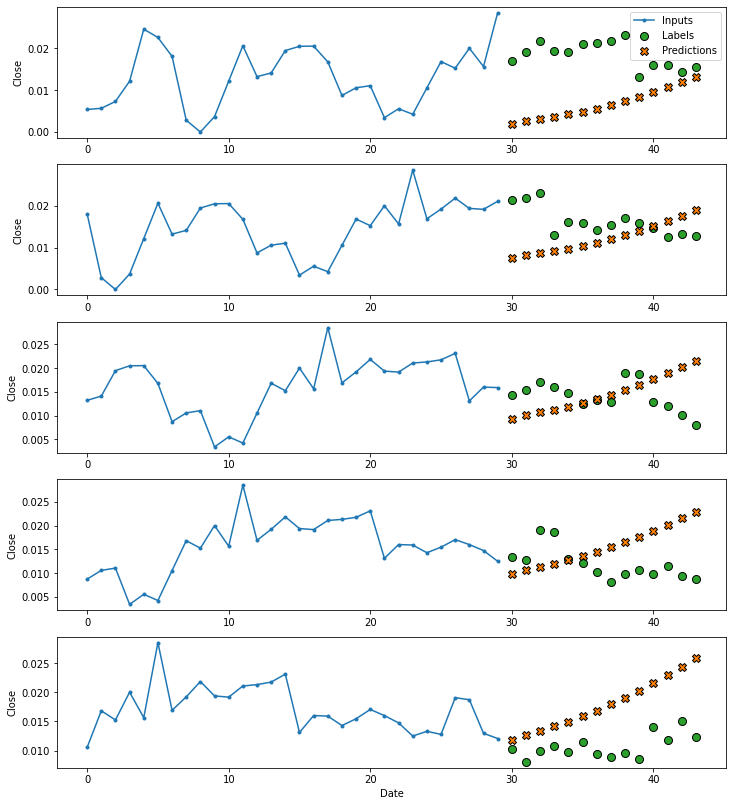

In [27]:
history = compile_and_fit(multi_lstm_model, muti_window)

IPython.display.clear_output()
multi_val_performance = multi_lstm_model.evaluate(muti_window.val)
multi_performance = multi_lstm_model.evaluate(muti_window.test, verbose=0)
muti_window.plot(plot_col=target, model=multi_lstm_model, max_subplots=5)

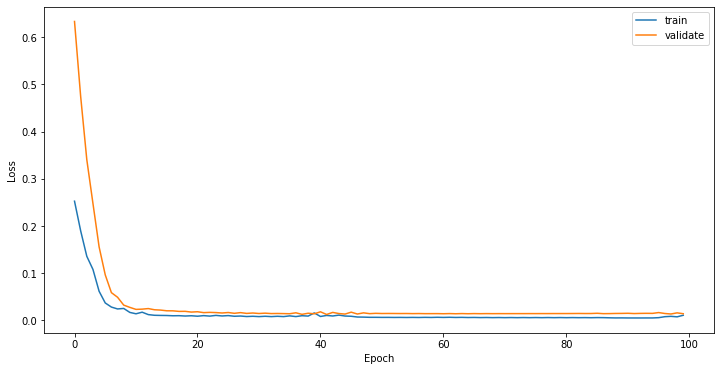

In [28]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

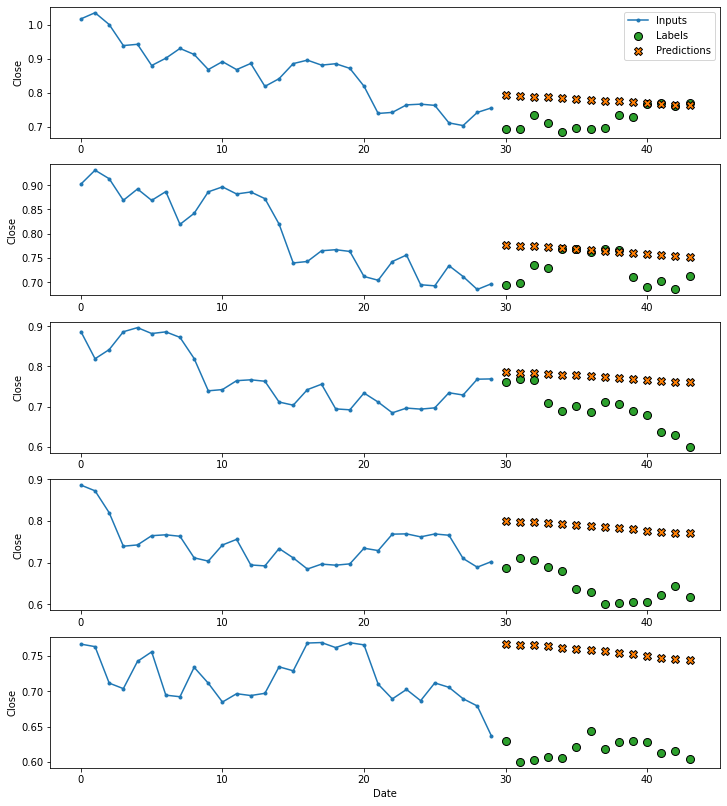

In [29]:
muti_window.plot(plot_col=target, example=muti_window.test, model=multi_lstm_model, max_subplots=5)

In [30]:
print("Validation")
print(f'Loss: {multi_val_performance[0]}, MAE: {multi_val_performance[1]}')
print("Test")
print(f'Loss: {multi_performance[0]}, MAE: {multi_performance[1]}')

Validation
Loss: 0.014342531561851501, MAE: 0.10187961161136627
Test
Loss: 0.017124926671385765, MAE: 0.11046919226646423


In [31]:
(multi_val_performance[1] * scale_range)["Close"], (multi_performance[1] * scale_range)["Close"]

(5593.3599736478955, 6064.942225157824)